In [1]:
%matplotlib inline
import os
os.environ['PY3_PROD'] = '1'
%load_ext autoreload
%autoreload 2
os.system('kinit')

1

In [8]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
from pycmqlib3.utility import dbaccess, dataseries, misc
from pycmqlib3.analytics.tstool import *
from pycmqlib3.analytics.btmetrics import *
from pycmqlib3.analytics.backtest_utils import *

In [3]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
matplotlib.rcParams['figure.figsize'] = (12, 8)


In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

# define product groups and start times

In [5]:
ferrous_products_mkts = ['rb', 'hc', 'i', 'j', 'jm']
ferrous_mixed_mkts = ['ru', 'FG', 'SM', "SF", 'nr', 'SA', 'UR'] # 'ZC', 
base_metal_mkts = ['cu', 'al', 'zn', 'pb', 'ni', 'sn', 'ss']
precious_metal_mkts = ['au', 'ag']
ind_metal_mkts = ferrous_products_mkts + ferrous_mixed_mkts + base_metal_mkts  
petro_chem_mkts = ['l', 'pp', 'v', 'TA', 'MA', 'bu', 'sc', 'fu', 'eg', 'eb', 'lu', 'pg', 'PF'] 
ind_all_mkts = ind_metal_mkts + petro_chem_mkts
ags_oil_mkts = ['m', 'RM', 'y', 'p', 'OI', 'a', 'c', 'cs', 'b'] #, 'b']
ags_soft_mkts = ['CF', 'SR', 'jd', 'AP', 'sp', 'CJ', 'lh', 'PK', 'CY'] # 'CY',] 

ags_all_mkts = ags_oil_mkts + ags_soft_mkts

eq_fut_mkts = ['IF', 'IH', 'IC']
bond_fut_mkts = ['T', 'TF', 'TS']

fin_all_mkts = eq_fut_mkts + bond_fut_mkts
commod_all_mkts = ind_all_mkts + ags_all_mkts + precious_metal_mkts
all_markets = commod_all_mkts + fin_all_mkts

daily_start_dict = { 'c': datetime.date(2011,1,1), 'm': datetime.date(2011,1,1),
    'y': datetime.date(2011,1,1), 'l': datetime.date(2011,1,1), 'rb':datetime.date(2011,1,1),
    'p': datetime.date(2011,1,1), 'cu':datetime.date(2011,1,1), 'al':datetime.date(2011,1,1),
    'zn':datetime.date(2011,1,1), 'au':datetime.date(2015,12,1), 'v': datetime.date(2011,1,1),
    'a': datetime.date(2011,1,1), 'ru':datetime.date(2011,1,1), 'ag':datetime.date(2012,6,1),
    'i': datetime.date(2014,1,1), 'j': datetime.date(2012,6,1), 'jm':datetime.date(2013,7,1),
    'CF':datetime.date(2012,5,1),  'TA':datetime.date(2012,4,15),
    'PM':datetime.date(2013,10,1), 'RM':datetime.date(2013,1,1),  'SR':datetime.date(2013,1,1),
    'FG':datetime.date(2013,1,1),  'OI':datetime.date(2013,5,1),  'RI':datetime.date(2013,1,1),
    'WH':datetime.date(2014,5,1),  'pp':datetime.date(2014,5,1),
    'IF':datetime.date(2010,5,1),  'MA':datetime.date(2012,1,1),  'TF':datetime.date(2019,6,1),
    'IH':datetime.date(2015,5,1),  'IC':datetime.date(2015,5,1),  'cs':datetime.date(2015,2,1),
    'jd':datetime.date(2014,5,1),  'ni':datetime.date(2015,9,1),  'sn':datetime.date(2017,5,1),
    'ZC':datetime.date(2013,11,1), 'hc':datetime.date(2016, 4, 1), 'SM': datetime.date(2017,1,1),
    'SF': datetime.date(2017,9,1), 'CY': datetime.date(2017, 9, 1), 'AP': datetime.date(2018, 1, 1),
    'TS': datetime.date(2018, 9, 1), 'fu': datetime.date(2018, 9, 1), 'sc': datetime.date(2018, 10, 1),
    'b': datetime.date(2018, 1, 1), 'pb': datetime.date(2016, 7, 1), 'bu': datetime.date(2015,9,15),
    'T':datetime.date(2019,4,1), 'ss': datetime.date(2020, 5, 1), 'sp': datetime.date(2019, 5, 1),
    'CJ': datetime.date(2019, 8, 9), 'UR': datetime.date(2019, 8, 9), 'SA': datetime.date(2020, 1, 1),
    'eb': datetime.date(2020, 2, 1), 'eg': datetime.date(2019, 4, 2), 'rr': datetime.date(2019, 9, 1),
    'pg': datetime.date(2020, 9, 5), 'lu': datetime.date(2020, 10, 1), 'nr': datetime.date(2020,1,1),
    'lh': datetime.date(2021,5,1), 'PF': datetime.date(2021,1,1), 'PK': datetime.date(2021,4,1), }

In [6]:
lead_lag_config = {
    'll_left': -20,
    'll_right': 120,
    'll_spacing': 5,
    'll_sub_win': [(datetime.date(2008, 1, 1), datetime.date(2016, 12, 31)), 
                   (datetime.date(2017, 1, 1), datetime.date(2022, 12, 31)),],
}

ll_keys = ['fullsample'] + ['%s:%s' % (sd.strftime('%Y-%b-%d'), ed.strftime('%Y-%b-%d')) for sd, ed in lead_lag_config['ll_sub_win']]


# load historical data

In [7]:
fields = ['contract', 'open', 'high', 'low', 'close', 'volume', 'openInterest', 'diff_oi', 'expiry', 'mth', 'shift']

start_date = datetime.date(2010,1,1)
end_date = datetime.date(2023,1,20)
shift_mode = 1
roll_name = 'hot'
roll_file_loc = "C:/dev/wtdev/config/"
sim_markets = all_markets
nb_cont = 2
freq='d1'

data_df = pd.DataFrame()

for prodcode in sim_markets:
    for nb in range(nb_cont):
        xdf = dataseries.nearby(prodcode,
                                nb+1,
                                start_date=start_date, 
                                end_date = end_date, 
                                shift_mode = shift_mode,
                                freq=freq, 
                                roll_name=roll_name, 
                                config_loc=roll_file_loc)
        xdf['expiry'] = xdf['contract'].map(misc.contract_expiry)
        xdf['contmth'] = xdf['contract'].map(misc.inst2contmth)
        xdf['mth'] = xdf['contmth'].apply(lambda x: x//100 * 12 + x % 100) 
        xdf['product'] = prodcode
        xdf['code'] = f'c{nb+1}'
        data_df = data_df.append(xdf)

df = pd.pivot_table(data_df.reset_index(), index='date', columns = ['product', 'code'], values = list(fields), aggfunc = 'last')
df = df.reorder_levels([1, 2, 0], axis=1).sort_index(axis=1)
df.columns.rename(['product', 'code', 'field',], inplace = True)
df.index = pd.to_datetime(df.index)
df.tail(5)

product         AP                                                         \
code            c1                                                          
field        close contract  diff_oi      expiry    high     low      mth   
date                                                                        
2023-01-16  8610.0   AP2305 -15788.0  2023-05-17  8785.0  8567.0  24281.0   
2023-01-17  8558.0   AP2305  -8904.0  2023-05-17  8677.0  8538.0  24281.0   
2023-01-18  8576.0   AP2305  -2695.0  2023-05-17  8630.0  8520.0  24281.0   
2023-01-19  8623.0   AP2305   2722.0  2023-05-17  8655.0  8416.0  24281.0   
2023-01-20  8724.0   AP2305  -6387.0  2023-05-17  8804.0  8536.0  24281.0   

product                                                                   \
code                                                 c2                    
field         open openInterest shift    volume   close contract diff_oi   
date                                                                       
2023-01-16  8785.0     197394.0   0.0  151022.0  8524.0   AP2310  -158.0   
2023-01-17  8600.0     188490.0   0.0   86593.0  8520.0   AP2310  -220.0   
2023-01-18  8580.0     185795.0   0.0   95134.0  8484.0   AP2310  -121.0   
2023-01-19  8567.0     188517.0   0.0  146575.0  8577.0   AP2310    74.0   
2023-01-20  8602.0     182130.0   0.0  160466.0  8610.0   AP2310  1086.0   

product                                                                     \
code                                                                         
field           expiry    high     low      mth    open openInterest shift   
date                                                                         
2023-01-16  2023-10-20  8645.0  8471.0  24286.0  8645.0      26318.0   0.0   
2023-01-17  2023-10-20  8567.0  8491.0  24286.0  8518.0      26098.0   0.0   
2023-01-18  2023-10-20  8558.0  8457.0  24286.0  8531.0      25977.0   0.0   
2023-01-19  2023-10-20  8609.0  8464.0  24286.0  8484.0      26051.0   0.0   
2023-01-20  2023-10-20  8698.0  8553.0  24286.0  8580.0      27137.0   0.0   

product                  CF                                                  \
code                     c1                                                   
field       volume    close contract  diff_oi      expiry     high      low   
date                                                                          
2023-01-16  3306.0  14290.0   CF2305  -8940.0  2023-05-17  14410.0  14265.0   
2023-01-17  1842.0  14375.0   CF2305  -4912.0  2023-05-17  14405.0  14245.0   
2023-01-18  1958.0  14705.0   CF2305  33537.0  2023-05-17  14745.0  14395.0   
2023-01-19  2114.0  14810.0   CF2305 -13536.0  2023-05-17  14915.0  14675.0   
2023-01-20  3122.0  14850.0   CF2305 -23324.0  2023-05-17  14930.0  14780.0   

product                                                                      \
code                                                            c2            
field           mth     open openInterest shift    volume    close contract   
date                                                                          
2023-01-16  24281.0  14375.0     734480.0   0.0  301491.0  14465.0   CF2309   
2023-01-17  24281.0  14280.0     729568.0   0.0  258257.0  14510.0   CF2309   
2023-01-18  24281.0  14415.0     763105.0   0.0  512623.0  14840.0   CF2309   
2023-01-19  24281.0  14710.0     749569.0   0.0  377365.0  14915.0   CF2309   
2023-01-20  24281.0  14790.0     726245.0   0.0  234358.0  14945.0   CF2309   

product                                                             \
code                                                                 
field      diff_oi      expiry     high      low      mth     open   
date                                                                 
2023-01-16  3264.0  2023-09-14  14560.0  14430.0  24285.0  14520.0   
2023-01-17   758.0  2023-09-14  14545.0  14415.0  24285.0  14470.0   
2023-01-18 -3772.0  2023-09-14  14880.0  14530.0  24285.0  14530.0   
2023

# Calculate features

In [ ]:
def roll_yield(df, vol_adj = False):
    

In [8]:
# param_dict = {
#     'basmom': [5, 10, 20, 30, 60,],
#     'mom': [5, 10, 20, 30, 60,],
#     'upratio': [20, 40, 60, 120],
#     'skew': [20, 40, 60, 120],
#     'kurt': [20, 40, 60, 120],
# }
param_dict = {
    'basmom': [],
    'mom': [],
    'upratio': [],
    'skew': [],
    'kurt': [],
}

win = 120
factor_name = 'ryield'
for prodcode in sim_markets:
    if shift_mode == 1:
        df[(prodcode, 'factor', 'ryield')]= np.log(df[(prodcode, 'c1', 'close')] - df[(prodcode, 'c1', 'shift')]) - \
                                            np.log(df[(prodcode, 'c2', 'close')] - df[(prodcode, 'c2', 'shift')])
    elif shift_mode == 0:
        df[(prodcode, 'factor', 'ryield')] = np.log(df[(prodcode, 'c1', 'close')])-np.log(df[(prodcode, 'c2', 'close')])
    elif shift_mode == 2:
        df[(prodcode, 'factor', 'ryield')]= np.log(df[(prodcode, 'c1', 'close')])-np.log(df[(prodcode, 'c2', 'close')]) - \
                                            df[(prodcode, 'c1', 'shift')] + df[(prodcode, 'c2', 'shift')]
    df[(prodcode, 'factor', 'ryield')] = df[(prodcode, 'factor', 'ryield')]/(df[(prodcode, 'c2', 'mth')] - df[(prodcode, 'c1', 'mth')])*12.0
    
    
#    df[(prodcode, 'factor', factor_name)] = df[(prodcode, 'factor', 'ryield')]/df[(prodcode, 'factor', 'ryield')].pow(2).rolling(win).mean().pow(0.5)
    
#     for win in param_dict['basmom']:
#         df[(prodcode, 'factor', 'basmom%s' % (win))] = df[(prodcode, 'c0', 'log_ret')].rolling(win).sum() \
#                                                         - df[(prodcode, 'c1', 'log_ret')].rolling(win).sum()    
#     for win in param_dict['mom']:
#         df[(prodcode, 'factor', 'mom%s' % (win))] = df[(prodcode, 'c0', 'log_ret')].rolling(win).sum()
    
#     for win in param_dict['upratio']:
#         df[(prodcode, 'factor', 'upratio%s' % (win))] = df[(prodcode, 'c0', 'log_ret')].rolling(win).agg(lambda x: (x>0).sum()/win)-0.5
    
#     for win in param_dict['skew']:
#         df[(prodcode, 'factor', 'skew%s' % (win))] = df[(prodcode, 'c0', 'log_ret')].rolling(win).skew()
        
#     for win in param_dict['kurt']:
#         df[(prodcode, 'factor', 'kurt%s' % (win))] = df[(prodcode, 'c0', 'log_ret')].rolling(win).kurt()


In [9]:
df_pxchg = df[df.columns[(df.columns.get_level_values(2) == 'price_chg') & (df.columns.get_level_values(1) == 'c1')]].droplevel([1, 2],axis=1)

df_in = df[df.columns[(df.columns.get_level_values(2) == factor_name) & (df.columns.get_level_values(1) == 'factor')]].droplevel([1, 2],axis=1)    
print(df_pxchg, df_in)

product        al      cu     hc     i    rb   sc     ss     zn
date                                                           
2011-01-04    0.0     0.0    NaN   NaN   0.0  NaN    NaN    0.0
2011-01-05  -40.0 -1060.0    NaN   NaN -29.0  NaN    NaN -230.0
2011-01-06  100.0   860.0    NaN   NaN  16.0  NaN    NaN  325.0
2011-01-07  -75.0 -1880.0    NaN   NaN -16.0  NaN    NaN -665.0
2011-01-10   15.0   210.0    NaN   NaN  41.0  NaN    NaN  -30.0
...           ...     ...    ...   ...   ...  ...    ...    ...
2022-12-15    0.0  -530.0   82.0  20.5  95.0  7.5  -30.0 -250.0
2022-12-16  -60.0  -720.0  -37.0  -8.0 -12.0 -0.7 -360.0 -475.0
2022-12-19 -200.0  -150.0 -111.0 -25.0 -98.0 -2.7 -585.0 -300.0
2022-12-20   50.0   -50.0   16.0   6.0  21.0  2.2 -265.0 -345.0
2022-12-21   65.0   700.0   63.0  20.0  55.0  6.6   15.0   35.0

[2908 rows x 8 columns] product           rb        hc         i        cu        al        zn  \
date                                                                 

# TS signals

In [10]:
fill_backward = False
smooth_win = 1
sig_smooth = tstool.exp_smooth(df_in, hl = smooth_win, fill_backward=fill_backward)

demean = False
mean_win = 244
vol_win = 244
if demean:
    sig_scored = tstool.ts_score(sig_smooth, hl_mean=mean_win, min_obs_mean=mean_win, fill_backward_mean=fill_backward, 
                          hl_vol=vol_win, min_obs_vol=vol_win, fill_backward_vol=fill_backward)
else:
    sig_scored = tstool.ts_scale(sig_smooth, hl = vol_win, min_obs=vol_win, fill_backward=fill_backward)

signal_cap = 2.0

score_capped = tstool.cap(sig_scored, -signal_cap, signal_cap)
score_filled = tstool.filldown(score_capped, 2)
score = tstool.lag(score_filled, 1)


# XS signals

In [ ]:
fill_backward = False
smooth_win = 1
sig_smooth = tstool.exp_smooth(df_in, hl = smooth_win, fill_backward=fill_backward)

demean = True
mean_win = 244
vol_win = 244

sig_scored = tstool.xs_score(sig_smooth, demean=demean, hl=vol_win)

signal_cap = None
if signal_cap:
    sig_scored = tstool.cap(sig_scored, -signal_cap, signal_cap)

score_filled = tstool.filldown(sig_scored, 2)
score = tstool.lag(score_filled, 1)

# scaling signals by vol

In [ ]:
vol_scale = 20
asset_vol = tstool.exp_smooth(df_pxchg**2, hl=vol_scale, fill_backward=fill_backward)**0.5
holding = score/asset_vol

In [11]:
commod_list = holding.columns #['hc']
btmetrics = MetricsBase(holdings = holding[commod_list], returns = df_pxchg[commod_list])


# lead-lag plot

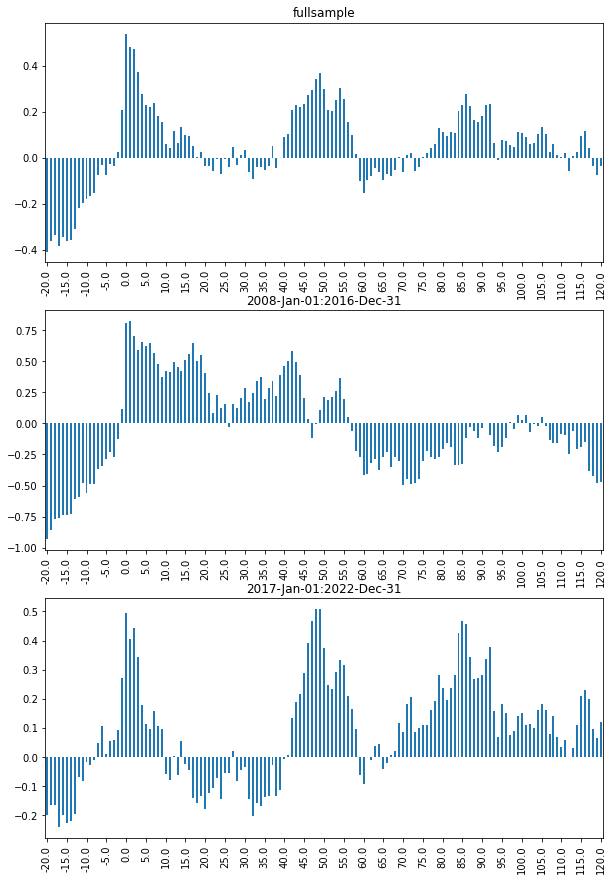

long short PNL stats: total pnl
 {'asset_pnl': product              rb           hc           i            cu            al  \
date                                                                           
2011-01-04          NaN          NaN         NaN           NaN           NaN   
2011-01-05          NaN          NaN         NaN           NaN           NaN   
2011-01-06          NaN          NaN         NaN           NaN           NaN   
2011-01-07          NaN          NaN         NaN           NaN           NaN   
2011-01-10          NaN          NaN         NaN           NaN           NaN   
...                 ...          ...         ...           ...           ...   
2022-12-15  4022.475183 -3298.096214  153.456245    -23.183269      0.000000   
2022-12-16  -425.317885  1279.971079  -64.928470  -1695.953194  -5433.639864   
2022-12-19 -4027.702372  4907.336755 -249.931666    178.950509 -24233.675234   
2022-12-20  1074.430139  -276.212441   62.491073    -90.480659   5761.299

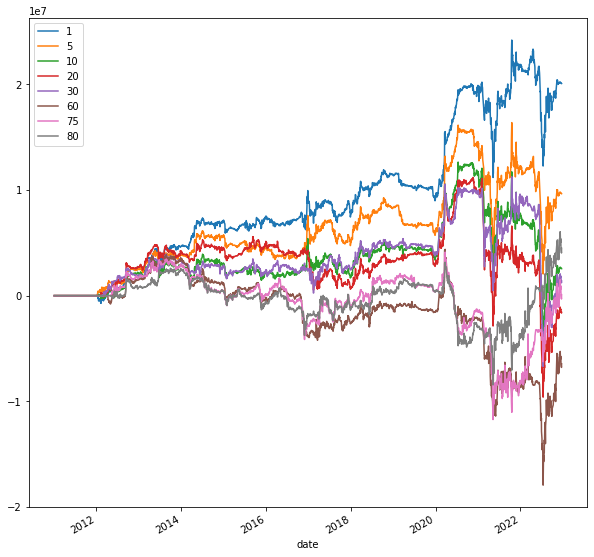

smoothed PNL
                  1         5         10        20        30        60  \
sharpe     0.424388  0.237200  0.148029  0.092113  0.064938  0.013403   
sharpe_fh  0.467961  0.334931  0.242689  0.111928  0.023094 -0.094552   
sharpe_sh  0.449164  0.226516  0.131231  0.099337  0.095688  0.079178   

                 75        80  
sharpe    -0.002124 -0.006365  
sharpe_fh -0.115637 -0.120250  
sharpe_sh  0.071864  0.069724  


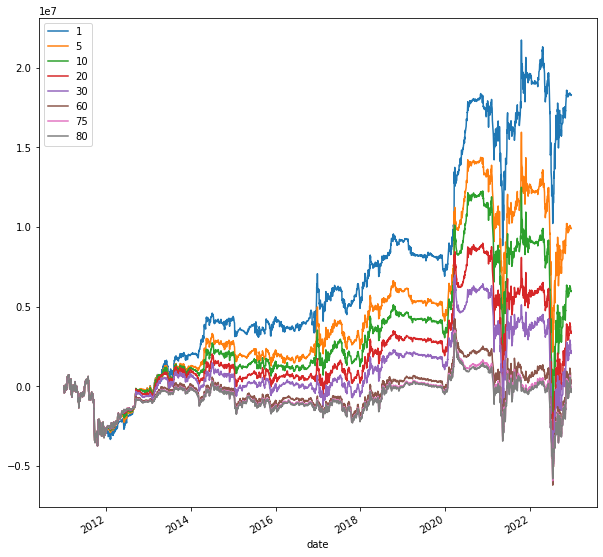

rolling window results: tilt:
 {'asset_pnl': product              rb           hc           i             cu            al  \
date                                                                            
2011-01-04          NaN          NaN         NaN            NaN           NaN   
2011-01-05          NaN          NaN         NaN            NaN           NaN   
2011-01-06          NaN          NaN         NaN            NaN           NaN   
2011-01-07          NaN          NaN         NaN            NaN           NaN   
2011-01-10          NaN          NaN         NaN            NaN           NaN   
...                 ...          ...         ...            ...           ...   
2022-12-15  4094.248375  4814.182067  731.456287 -176157.657403      0.000000   
2022-12-16  -516.208913 -2156.172578 -284.683485 -238257.348558  -6704.824161   
2022-12-19 -4209.442487 -6414.986583 -885.649532  -49334.502674 -22555.267061   
2022-12-20   901.840910   919.020661  211.895160  -16331.278084 

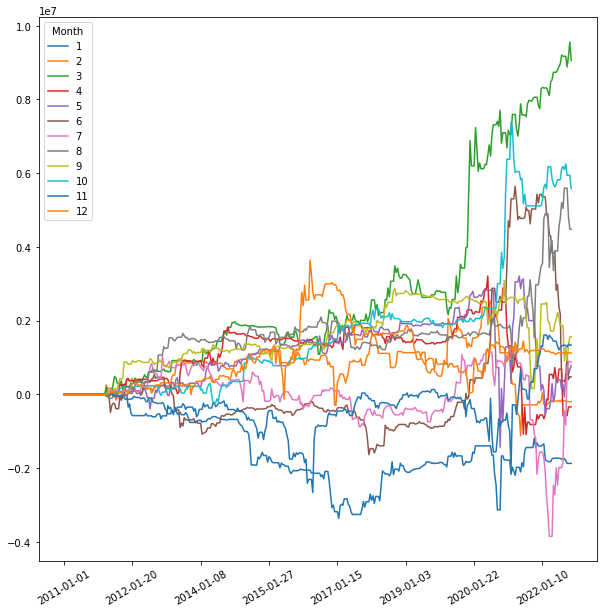

monthday sharpe stats
 MonthDay        1-4     10-14     15-20       5-9       >20
sharpe    -0.281333  0.360488  0.429424  1.196867  2.473581
sharpe_fh  0.062936  0.812157  0.644833  0.845437  2.282985
sharpe_sh -0.437477  0.176575  0.405129  1.540967  2.632124


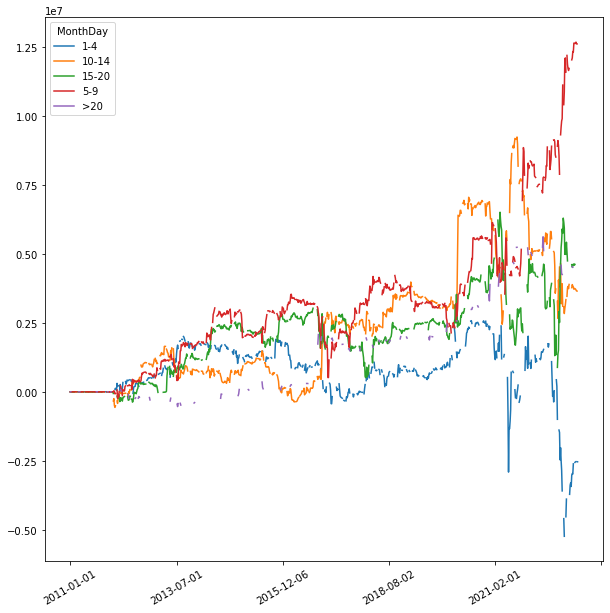

week sharpe stats
 WeekDay           0         1         2         3         4
sharpe     0.127932  1.155465  0.161905 -0.184172  1.453278
sharpe_fh  1.376720  0.889846 -0.037388  0.523738  1.296173
sharpe_sh -0.479939  1.473865  0.348178 -0.471222  1.733000


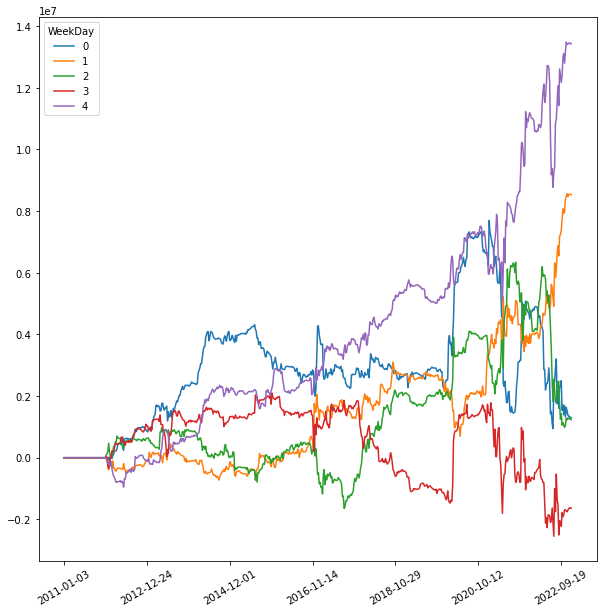

annual sharpe stats
 Year       2011      2012      2013      2014      2015      2016      2017  \
sharpe      NaN  1.283418  1.130351  1.365574  0.174024  0.345670 -0.387149   
sharpe_fh   NaN  0.433570  0.666956  2.435475 -0.455694 -0.942969 -0.136061   
sharpe_sh   NaN  2.838740  1.649217  0.141861  0.483345  0.797757 -0.632676   

Year           2018      2019      2020      2021      2022  
sharpe     1.665705 -1.053999  2.401081  0.172580 -0.089303  
sharpe_fh  1.584175 -1.156773  3.196727 -0.275850 -1.258298  
sharpe_sh  1.890305 -0.963018  1.137854  0.711877  0.864199  


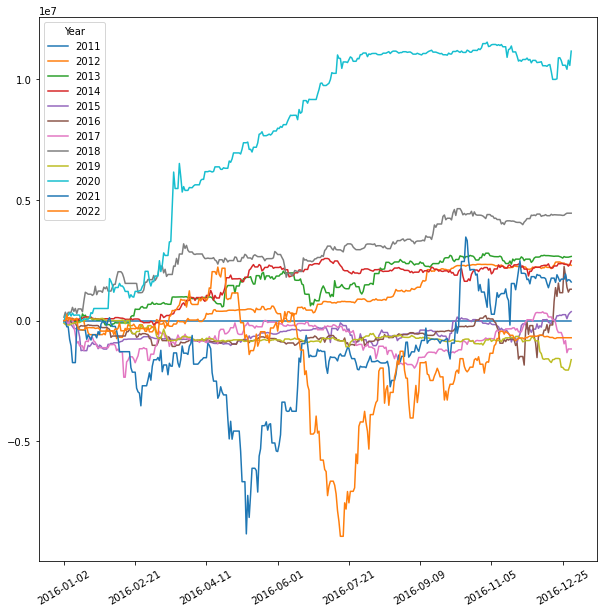

{'turnover_perc_y': product            rb         hc          i         cu         al         zn  \
date                                                                           
2011-12-31        NaN        NaN        NaN        NaN        NaN        NaN   
2012-12-31        NaN        NaN        NaN  55.113879  36.480924  29.965870   
2013-12-31        NaN        NaN        NaN  37.345906  38.348346  59.315684   
2014-12-31  25.291422        NaN        NaN  24.404548  32.087042  36.912701   
2015-12-31  32.700730        NaN  14.923472  26.257785  48.530819  44.274935   
2016-12-31  25.941665        NaN   9.360357  56.841647  26.820105  41.367472   
2017-12-31  16.766814        NaN  17.761120  33.584045  14.310560  39.527163   
2018-12-31  10.216746   6.335120  30.008038  28.539730  22.109552  18.506158   
2019-12-31   7.532250   6.449651   7.571748  47.670131  53.060175  23.879042   
2020-12-31  15.912286  10.932775   9.678882  48.232307  22.384076  33.446817   
2021-12-31  34.00631

In [12]:
ll_left = lead_lag_config['ll_left']
ll_right = lead_lag_config['ll_right']
spacing = lead_lag_config['ll_spacing']

leadlag_df = btmetrics.lead_lag(ll_limit_left=ll_left, 
                                ll_limit_right=ll_right,
                                ll_sub_windows=lead_lag_config['ll_sub_win'])

fig, ax = plt.subplots(len(ll_keys), 1)
fig.set_figheight(15)
fig.set_figwidth(10)

for i, key in enumerate(ll_keys):
    ts = leadlag_df['leadlag_sharpes'].loc[key]
    ts.plot(kind='bar', ax = ax[i], title = f'lead_lag: {key}')
    new_ticks = np.linspace(ll_left, ll_right, (ll_right-ll_left)//spacing+1)
    ax[i].set_xticks(np.interp(new_ticks, ts.index, np.arange(ts.size)))
    ax[i].set_xticklabels(new_ticks)

plt.show()


In [26]:
def display_results(results, desc='', plot_asset = False):
    sharpe = results['sharpe']
    asset_sharpe = results['sharpe']
    print(f"{desc} pnl sharpe:\n{sharpe}\n{asset_sharpe}\n")
    pnl_df = results['portfolio_cumpnl']
    pnl_df.plot(title=f'{desc} cPNL: total')
    plt.show()
    if plot_asset:
        asset_df = results['asset_cumpnl']
        asset_df.plot(title=f'{desc} cPNL by asset')
        plt.show()
    

# long short plot

long short full pnl sharpe:
sharpe       0.540049
sharpe_fh    0.822031
sharpe_sh    0.499458
Name: total, dtype: float64
sharpe       0.540049
sharpe_fh    0.822031
sharpe_sh    0.499458
Name: total, dtype: float64



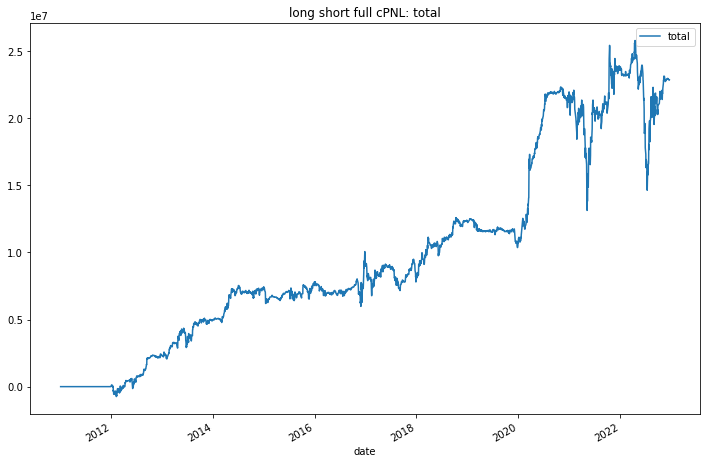

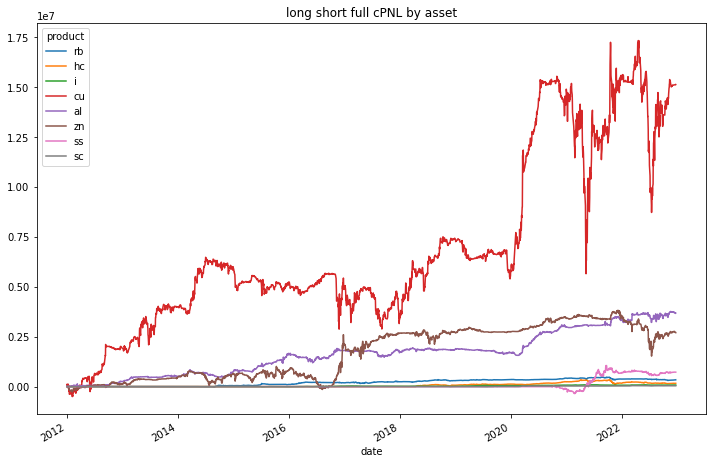

long only pnl sharpe:
sharpe       0.570292
sharpe_fh    0.767055
sharpe_sh    0.560629
Name: total, dtype: float64
sharpe       0.570292
sharpe_fh    0.767055
sharpe_sh    0.560629
Name: total, dtype: float64



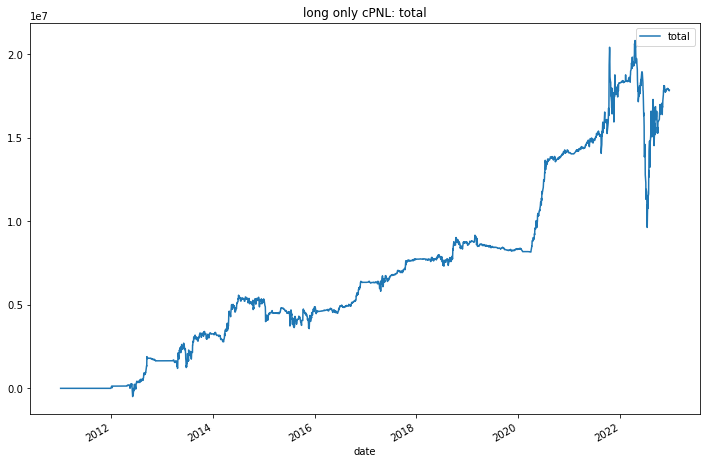

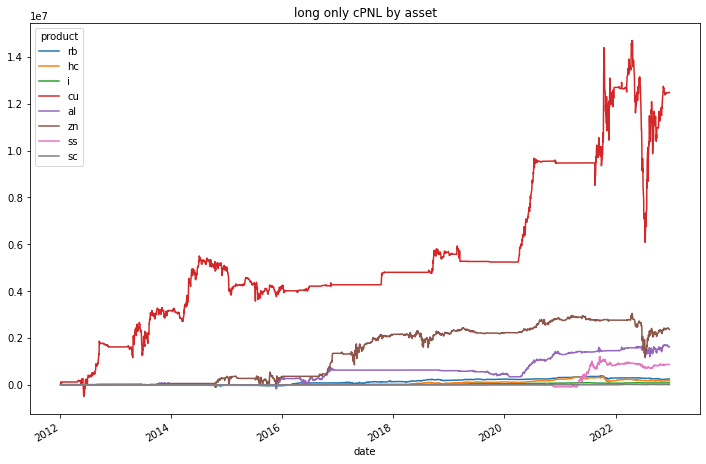

short only pnl sharpe:
sharpe       0.158741
sharpe_fh    0.328653
sharpe_sh    0.114483
Name: total, dtype: float64
sharpe       0.158741
sharpe_fh    0.328653
sharpe_sh    0.114483
Name: total, dtype: float64



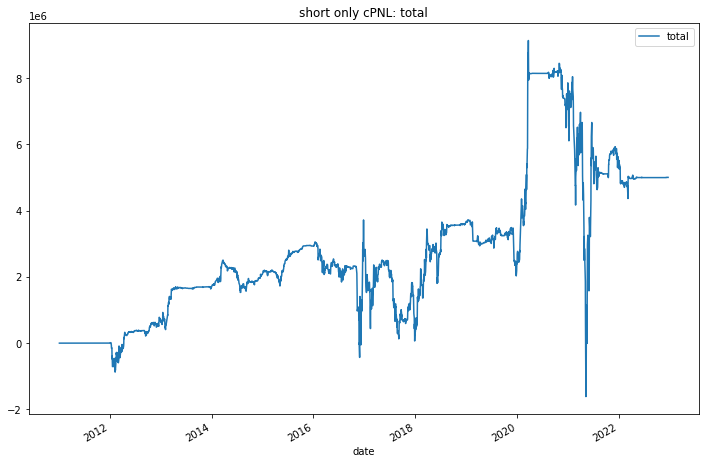

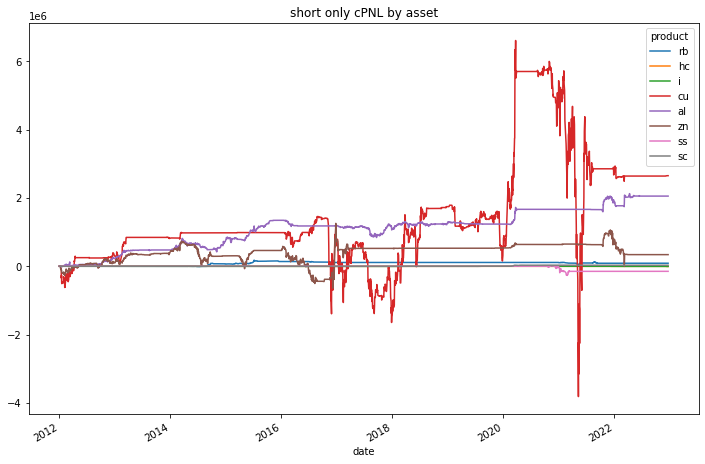

In [36]:
ls_pnl = btmetrics.long_short_pnl()
display_results(ls_pnl['total_pnl_stat'], desc='long short full', plot_asset = True)

display_results(ls_pnl['long_pnl_stat'], desc='long only', plot_asset = True)

display_results(ls_pnl['short_pnl_stat'], desc='short only', plot_asset = True)



# lagged and smoothing

lagged PNL
                  1         5         10        20        30        60  \
sharpe     0.481490  0.227349  0.061205 -0.037099  0.031686 -0.154970   
sharpe_fh  0.836636  0.644449  0.440873  0.404539  0.286068 -0.420536   
sharpe_sh  0.410815  0.117830 -0.053376 -0.172400 -0.034952 -0.091532   

                 75        80  
sharpe     0.002252  0.111715  
sharpe_fh -0.306892 -0.207927  
sharpe_sh  0.109578  0.237270  


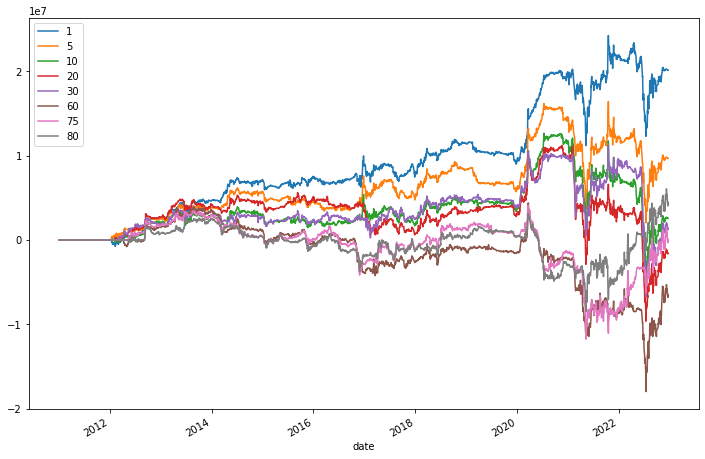

smoothed PNL
                  1         5         10        20        30        60  \
sharpe     0.424388  0.237200  0.148029  0.092113  0.064938  0.013403   
sharpe_fh  0.467961  0.334931  0.242689  0.111928  0.023094 -0.094552   
sharpe_sh  0.449164  0.226516  0.131231  0.099337  0.095688  0.079178   

                 75        80  
sharpe    -0.002124 -0.006365  
sharpe_fh -0.115637 -0.120250  
sharpe_sh  0.071864  0.069724  


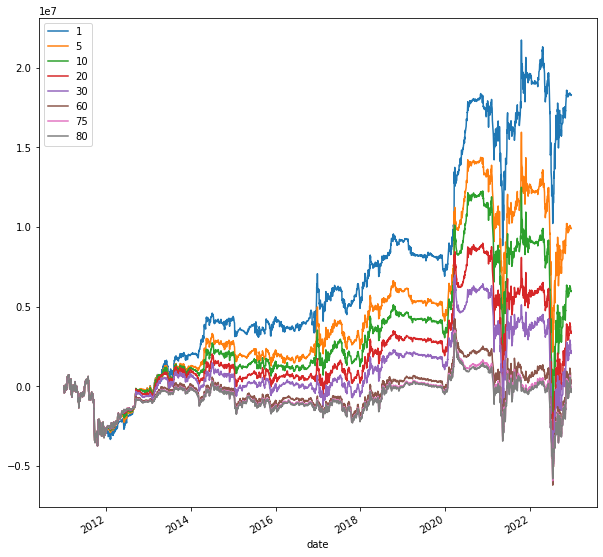

tilt (rolling) pnl sharpe:
sharpe       0.030715
sharpe_fh    0.165156
sharpe_sh   -0.007192
Name: total, dtype: float64
sharpe       0.030715
sharpe_fh    0.165156
sharpe_sh   -0.007192
Name: total, dtype: float64



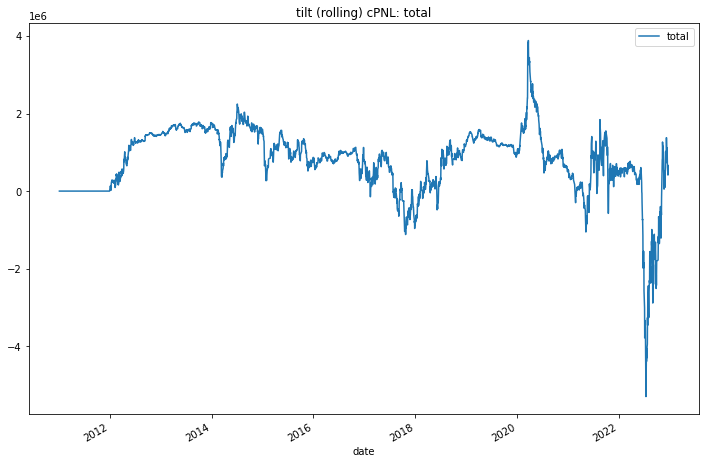

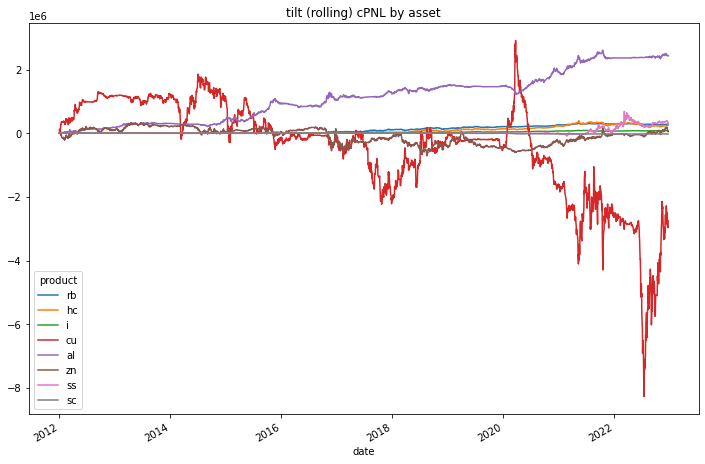

timing (rolling) pnl sharpe:
sharpe       0.600809
sharpe_fh    0.874938
sharpe_sh    0.574219
Name: total, dtype: float64
sharpe       0.600809
sharpe_fh    0.874938
sharpe_sh    0.574219
Name: total, dtype: float64



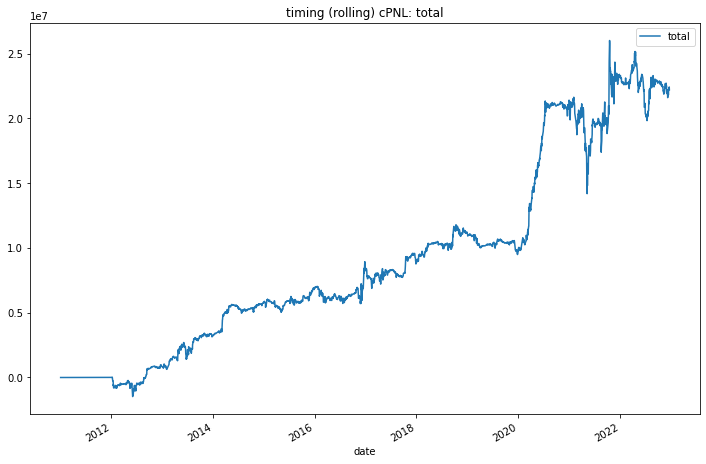

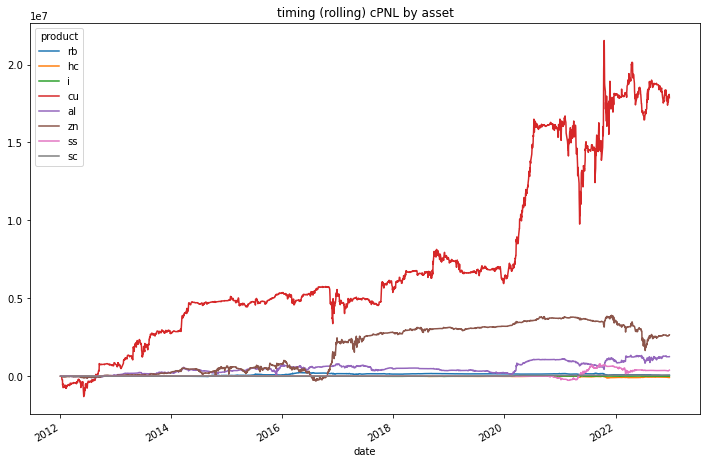

tilt (full sample) pnl sharpe:
sharpe       0.452381
sharpe_fh    0.336041
sharpe_sh    0.569836
Name: total, dtype: float64
sharpe       0.452381
sharpe_fh    0.336041
sharpe_sh    0.569836
Name: total, dtype: float64



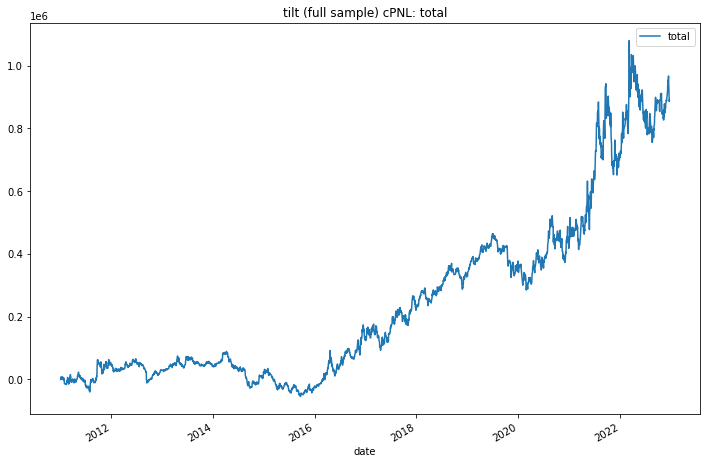

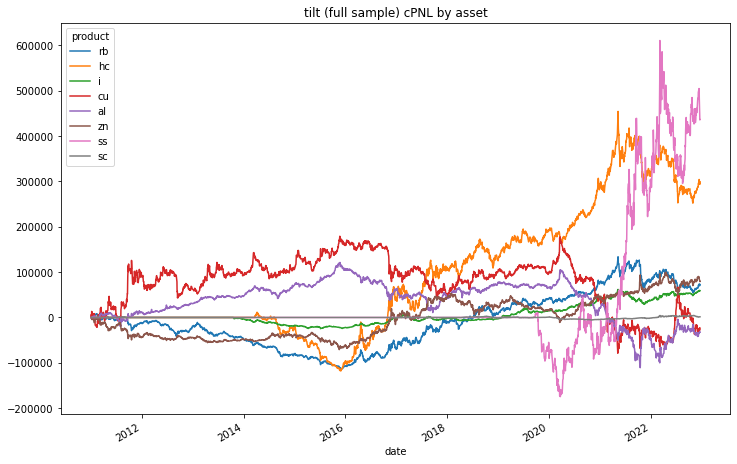

timing (full sample) pnl sharpe:
sharpe       0.521158
sharpe_fh    0.806804
sharpe_sh    0.474923
Name: total, dtype: float64
sharpe       0.521158
sharpe_fh    0.806804
sharpe_sh    0.474923
Name: total, dtype: float64



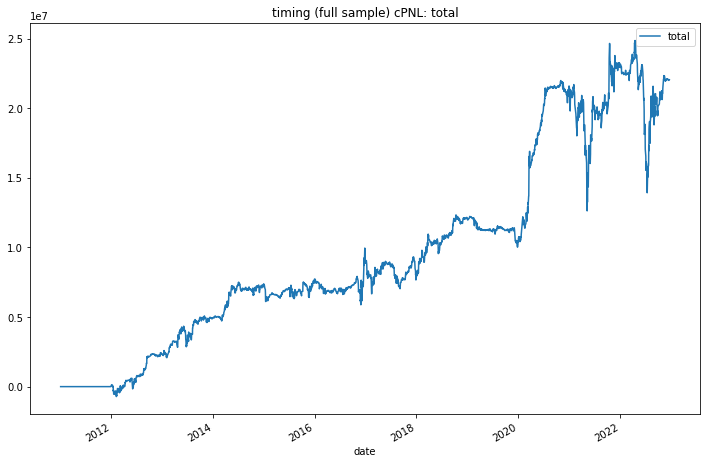

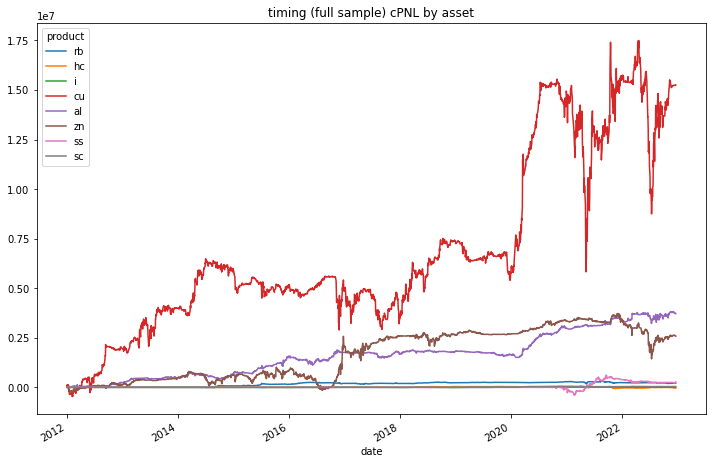

In [37]:
lagged = btmetrics.lagged_pnl(lags=[1, 5, 10, 20, 30, 60, 75, 80])
lagged['cumpnl'].plot()
print('lagged PNL\n', lagged['sharpe'])
plt.show()

smoothed = btmetrics.smoothed_pnl(smooth_hls=[1, 5, 10, 20, 30, 60, 75, 80])
smoothed['cumpnl'].plot(figsize=(10,10))
print('smoothed PNL\n', smoothed['sharpe'])
plt.show()

tilt_timing = btmetrics.tilt_timing(tilt_rolling_window=1*244) # default 3 years  tilt_rolling_window = 3 * 244 
display_results(tilt_timing['pnl_tilt_stat'], desc='tilt (rolling)', plot_asset = True)
display_results(tilt_timing['pnl_timing_stat'], desc='timing (rolling)', plot_asset = True)

display_results(tilt_timing['pnl_tilt_stat_full_sample'], desc='tilt (full sample)', plot_asset = True)
display_results(tilt_timing['pnl_timing_stat_full_sample'], desc='timing (full sample)', plot_asset = True)



# seasonal, month, week, annual pnl pattern

seasonal sharpe stats
 Month            1         2         3         4         5         6   \
sharpe    -0.584977 -0.055566  1.876227 -0.082396  0.135248  0.098579   
sharpe_fh -2.439441  1.130558  1.766893  1.469441  1.500585 -0.318623   
sharpe_sh  0.128620 -0.475357  2.450986 -0.609562 -0.151288  0.257854   

Month            7         8         9         10        11        12  
sharpe     0.178581  0.998385  0.418405  1.408710  0.294433  0.295507  
sharpe_fh -0.023288  2.048576  1.982131  1.752230 -0.512112  1.257678  
sharpe_sh  0.280129  0.825712  0.074509  1.565186  0.803898 -0.982276  


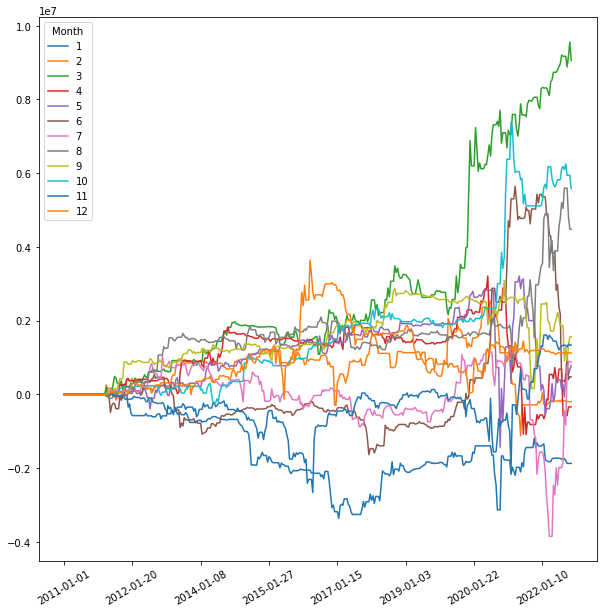

monthday sharpe stats
 MonthDay        1-4     10-14     15-20       5-9       >20
sharpe    -0.281333  0.360488  0.429424  1.196867  2.473581
sharpe_fh  0.062936  0.812157  0.644833  0.845437  2.282985
sharpe_sh -0.437477  0.176575  0.405129  1.540967  2.632124


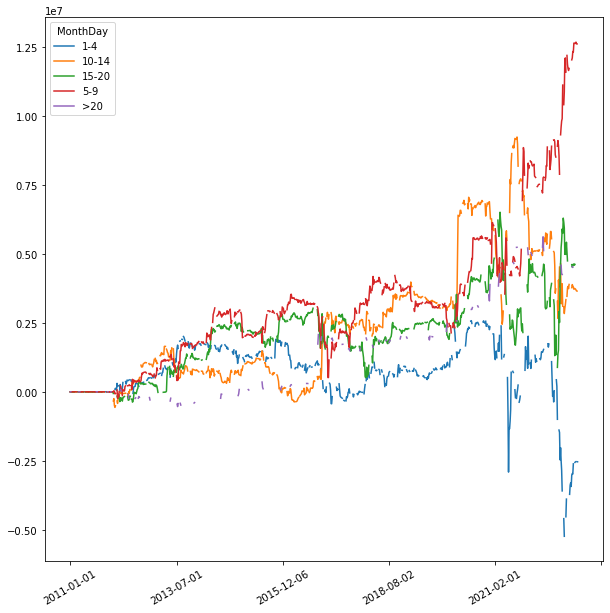

week sharpe stats
 WeekDay           0         1         2         3         4
sharpe     0.127932  1.155465  0.161905 -0.184172  1.453278
sharpe_fh  1.376720  0.889846 -0.037388  0.523738  1.296173
sharpe_sh -0.479939  1.473865  0.348178 -0.471222  1.733000


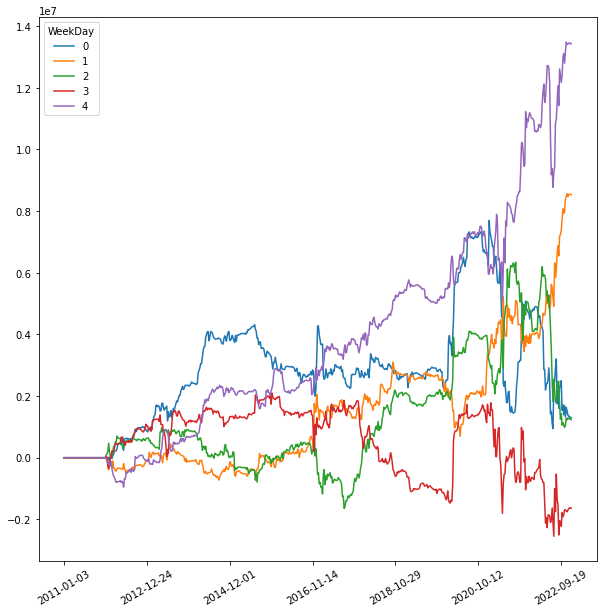

annual sharpe stats
 Year       2011      2012      2013      2014      2015      2016      2017  \
sharpe      NaN  1.283418  1.130351  1.365574  0.174024  0.345670 -0.387149   
sharpe_fh   NaN  0.433570  0.666956  2.435475 -0.455694 -0.942969 -0.136061   
sharpe_sh   NaN  2.838740  1.649217  0.141861  0.483345  0.797757 -0.632676   

Year           2018      2019      2020      2021      2022  
sharpe     1.665705 -1.053999  2.401081  0.172580 -0.089303  
sharpe_fh  1.584175 -1.156773  3.196727 -0.275850 -1.258298  
sharpe_sh  1.890305 -0.963018  1.137854  0.711877  0.864199  


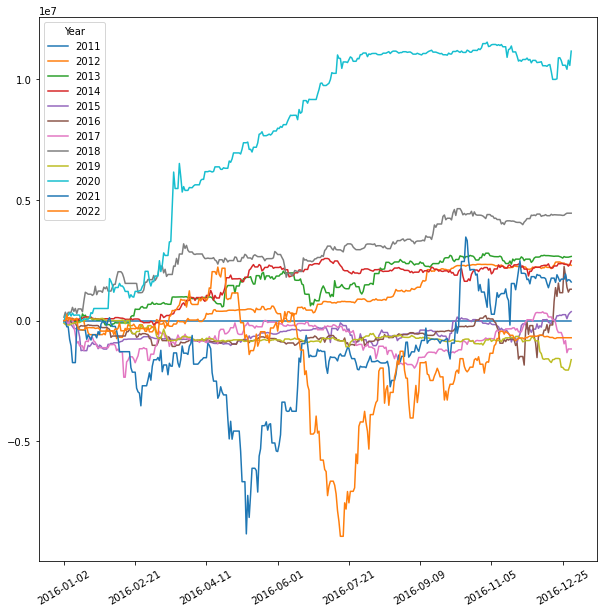

In [40]:
seasonal_pnl = btmetrics.seasonal_pnl()
cumpnl = seasonal_pnl['cumlog_pnl']
cumpnl.set_index(cumpnl.index.astype('str')).plot(rot=30, figsize = (10,10))
print('seasonal sharpe stats\n', seasonal_pnl['sharpe_stats'])
plt.show()


monthday_pnl = btmetrics.monthday_pnl()
cumpnl = monthday_pnl['cumlog_pnl']
cumpnl.set_index(cumpnl.index.astype('str')).plot(rot=30, figsize = (10,10))
print('monthday sharpe stats\n', monthday_pnl['sharpe_stats'])
plt.show()


week_pnl = btmetrics.week_pnl()
cumpnl = week_pnl['cumlog_pnl']
cumpnl.set_index(cumpnl.index.astype('str')).plot(rot=30, figsize = (10,10))
print('week sharpe stats\n', week_pnl['sharpe_stats'])
plt.show()


annual_pnl = btmetrics.annual_pnl()
cumpnl = annual_pnl['cumlog_pnl']
cumpnl.set_index(cumpnl.index.astype('str')).plot(rot=30, figsize = (10,10))
print('annual sharpe stats\n', annual_pnl['sharpe_stats'])
plt.show()


In [42]:
turnover = btmetrics.turnover()
print('turnover portfolio perc:\n%s\n' % (turnover['turnover_portfolio_perc_y']))

print('turnover perc by product:\n%s\n' % (turnover['turnover_perc_y']))

print('turnover annual change counts:\n%s\n' % (turnover['change_counts_annual']))

print('turnover monthly change counts:\n%s\n' % (turnover['change_counts_monthly']))

turnover portfolio perc:
date
2011-12-31          NaN
2012-12-31    39.439416
2013-12-31    42.100781
2014-12-31    31.796393
2015-12-31    38.887847
2016-12-31    36.440278
2017-12-31    29.050757
2018-12-31    21.947769
2019-12-31    35.219638
2020-12-31    32.447646
2021-12-31    33.615148
2022-12-31    29.200627
Freq: A-DEC, dtype: float64

turnover perc by product:
product            rb         hc          i         cu         al         zn  \
date                                                                           
2011-12-31        NaN        NaN        NaN        NaN        NaN        NaN   
2012-12-31        NaN        NaN        NaN  55.113879  36.480924  29.965870   
2013-12-31        NaN        NaN        NaN  37.345906  38.348346  59.315684   
2014-12-31  25.291422        NaN        NaN  24.404548  32.087042  36.912701   
2015-12-31  32.700730        NaN  14.923472  26.257785  48.530819  44.274935   
2016-12-31  25.941665        NaN   9.360357  56.841647  26.820105  

C:\dev\pyktrader3\pycmqlib3\analytics\tstool.py:80: RuntimeWarning: invalid value encountered in multiply
  nd_out = np.empty(nd_in.shape) * np.NaN
